In [6]:
from modules.models import KdVPinn, create_dense_model
from modules.data import simulate_kdv
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [1]:
!git config --global user.name "Nadia Aiaseh"
!git config --global user.email "naiaseh@uwo.ca"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


In [5]:
!git restore PinnNew/KP.ipynb

In [6]:
!git pull origin

Updating f1e3949..d1186ef
Fast-forward
 PinnNew/KP.ipynb | 415 +------------------------------------------------------
 1 file changed, 1 insertion(+), 414 deletions(-)


In [4]:
k=6
c= 3.23
phi = 0
def phi_function_PBC(tx,nx=2000,nt=2000):
    offset =  0
    ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    u = u.numpy().reshape(nx,-1)

    diff = c
    for i in range(1,nt):
        un = u[0:nx-diff-1,i-1].copy() #shifted to right but still in the frame
        u[diff+1:nx,i]= un # shift them to the right for next time frame
        u[0:diff+1,i] = u[-diff-1:nx,i-1] # the remaining first diff points are the old points -10:-1
    u = tf.reshape(tf.convert_to_tensor(u),(-1,1))
    return u


def phi_function(tx):

    offset =  +12
    ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
    # ksi = tx[:, 1:2] + offset# in moving frame
    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u


def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

# x_start = 0
# length = 8*np.pi
x_start =  -50. #-10
length = 50.#10
time =  10

In [34]:
# soliton1 + soliton2
offset =  -8
c = 3.23
c2 = 0.5
def phi_function_solitonsAdded(tx,offset = -8):


    ksi = tx[:, 1:2]-c*tx[:,0:1] + 12
    ksi2 = tx[:, 1:2]-c2*tx[:,0:1] + offset
    # ksi = tx[:, 1:2] + offset# in moving frame
    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)
    u2 = c2 / (2*tf.cosh(np.sqrt(c2)*(ksi2/2))**2)
    u = tf.where(tf.math.is_nan(u), 0., u)
    u2 = tf.where(tf.math.is_nan(u2), 0., u2)
    total = u + u2
    return total

x_start =  -50.
length = 50
time =  10

c1 = c
def phi_function(tx, offset = -8, returnStuff = False):

    ksi1 = tx[:, 1:2] - c1*tx[:, 0:1] + 12
    ksi2 = tx[:, 1:2] - c2*tx[:, 0:1] + offset
    numer = 2*(c1-c2) * (c1*tf.cosh(np.sqrt(c2)*(ksi2)/2)**2 + c2* (tf.sinh(np.sqrt(c1)*(ksi1)/2)**2))
    denom = ((np.sqrt(c1)-np.sqrt(c2)) * tf.cosh((np.sqrt(c1) * ksi1 +np.sqrt(c2)* ksi2)/2) +  (np.sqrt(c1)+np.sqrt(c2)) * tf.cosh((np.sqrt(c1)*ksi1-np.sqrt(c2)*ksi2)/2))**2
    exact = numer/ denom
    exact = tf.where(tf.math.is_nan(exact), 0., exact)
    if returnStuff:
        return exact, denom, numer
    else:
        return exact

phi =0
def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

In [1]:
distanceOfSmallSoliton = np.arange(0,30,0.2)
diffs = np.zeros(distanceOfSmallSoliton.shape)
diffs2 = np.zeros(distanceOfSmallSoliton.shape)
diffs3 = np.zeros(distanceOfSmallSoliton.shape)
for ind, i in enumerate(distanceOfSmallSoliton):
  offset = -1 * i
  added = phi_function_solitonsAdded(tx_init, offset)
  interaction = phi_function(tx_init, offset)
  diffs[ind] = np.mean((added.numpy() - interaction.numpy())**2)
  diffs2[ind] = np.mean(added.numpy() - interaction.numpy())
  diffs3[ind] = np.mean(np.abs(added.numpy() - interaction.numpy()))


# plt.plot(distanceOfSmallSoliton, diffs,'.')
# plt.plot(distanceOfSmallSoliton, diffs2,'.')
plt.plot(distanceOfSmallSoliton, diffs3,'.')
plt.xlabel('distance')
plt.ylabel('mean absolute difference')

NameError: ignored

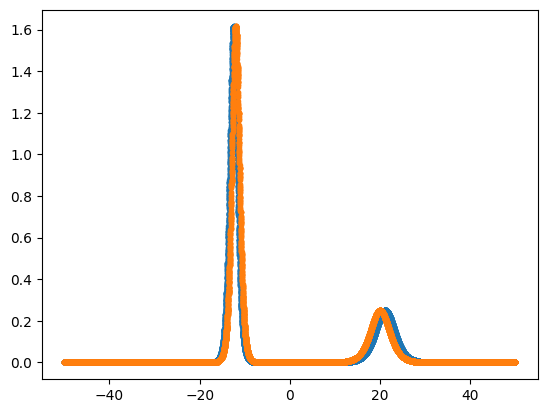

In [37]:
offset = -20
plt.plot( tx_init[:,1:],phi_function(tx_init, offset),'.')
plt.plot( tx_init[:,1:],phi_function_solitonsAdded(tx_init, offset),'.')

In [36]:

c1 = 3.23 #3.25
c2 = 0.5 #0.5

#c1 = 2.5
#c2 = 0.9
print(c1/c2)
phi = 0
# def phi_function(tx):
#     offset = 0
#     ksi1 = tx[:, 1:2] - c1*tx[:, 0:1] + 5
#     ksi2 = tx[:, 1:2] - c2*tx[:, 0:1] - 3

#     exact = 2*(c1-c2) * (c1*tf.cosh(tf.sqrt(c2)*(ksi2)/2)**2 + c2* (tf.sinh(tf.sqrt(c1)*(ksi1)/2)**2))/ ((tf.sqrt(c1)-tf.sqrt(c2)) * tf.cosh((tf.sqrt(c1) * ksi1 + tf.sqrt(c2)* ksi2)/2) +  (tf.sqrt(c1)+tf.sqrt(c2)) * tf.cosh((tf.sqrt(c1)*ksi1-tf.sqrt(c2)*ksi2)/2))**2
#     return exact

def phi_function(tx, returnStuff = False):
    offset = -8
    ksi1 = tx[:, 1:2] - c1*tx[:, 0:1] + 12
    ksi2 = tx[:, 1:2] - c2*tx[:, 0:1] + offset
    numer = 2*(c1-c2) * (c1*tf.cosh(np.sqrt(c2)*(ksi2)/2)**2 + c2* (tf.sinh(np.sqrt(c1)*(ksi1)/2)**2))
    denom = ((np.sqrt(c1)-np.sqrt(c2)) * tf.cosh((np.sqrt(c1) * ksi1 +np.sqrt(c2)* ksi2)/2) +  (np.sqrt(c1)+np.sqrt(c2)) * tf.cosh((np.sqrt(c1)*ksi1-np.sqrt(c2)*ksi2)/2))**2
    exact = numer/ denom
    exact = tf.where(tf.math.is_nan(exact), 0., exact)
    if returnStuff:
        return exact, denom, numer
    else:
        return exact


def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

x_start = -50
length = 50
time = 10

6.46


### start skipping if you don't want to model an animation of the exact periodic solution

In [ ]:
nt = 2000
nx = 2000
# int(np.pi*(dt**-1))+1
dx=(length-x_start)/(nx-1)
dt=time/(nt-1)
print(' dx is',dx/dt)



 dx is 6.3999999999999995


In [ ]:
x_flat = np.linspace(x_start, length, nx)
t_flat = np.linspace(0, time, nt)
x_flat = tf.convert_to_tensor(x_flat)
t_flat = tf.convert_to_tensor(t_flat)
t_, x_ = tf.meshgrid(t_flat, x_flat)
tx_samples = tf.concat((tf.reshape(t_, (-1, 1)), tf.reshape(x_, (-1, 1))), axis=1)
# tx = tf.convert_to_tensor(tx)
print(type(t_))
solution = phi_function_PBC(tx_samples,nx,nt)
print(solution.shape)
print(x_flat.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(4000000, 1)
(2000,)


In [ ]:
nx, nt = 256,201
solution = tf.reshape(solution, x_.shape)
print(solution[0,:].shape)

(2000,)


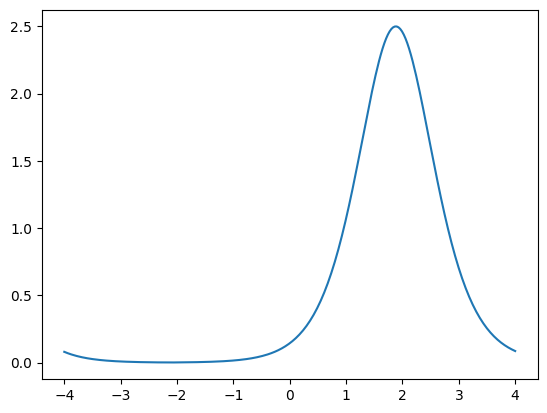

In [ ]:
plt.plot(x_flat, solution[:,10])

In [ ]:
u_boundary = tf.reshape(solution[0, :], (-1, 1))
boundary_indices = tf.random.shuffle(tf.range(nt, dtype=tf.int32), seed=42)[:nx]
u_boundary = tf.gather(u_boundary, boundary_indices)

In [ ]:
u_boundary.shape
plt.plot(x_flat[:nt],u_boundary,'.')

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( x_start, length))
ax.set_ylim((-0.01, np.sqrt(c)+0.5))

line, = ax.plot([], [], lw=2)
# line2, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    # line2.set_data([], [])
    return (line,)

In [ ]:
def animate(i):
    y=solution[:,i]
#     y2=vfull[:,i*10]
    line.set_data(x_flat,y,)

#     line2.set_data(x,y2)

    return(line,)

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int((nt-1)), interval=100) #frames is nt

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
f = r"KdVPBC.gif"
writergif = animation.PillowWriter(fps=10)
anim.save(f, writer=writergif)

# skip till here

In [ ]:
# (tx_samples, y_res), (tx_init, u_init), (tx_bnd_start, u_bnd_start_exact), (tx_bnd_end, u_bnd_end_exact), (tx_boundary, y_boundary)= \
#     simulate_kdv(n_samples = 10000, init_function= phi_function, bnd_fcn=boundary_function, xstart=x_start, length=length, time=time, compute_periodic = False, solver_function = None, nx = 1000, nt = 1000, shuffle_bnd = False, n_init=None, n_bndry=None,random_seed = 42, dtype=tf.float32)

In [9]:
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdv(30000, phi_function_solitonsAdded, boundary_function, length, time, x_start,random_seed = 42, dtype=tf.float32)


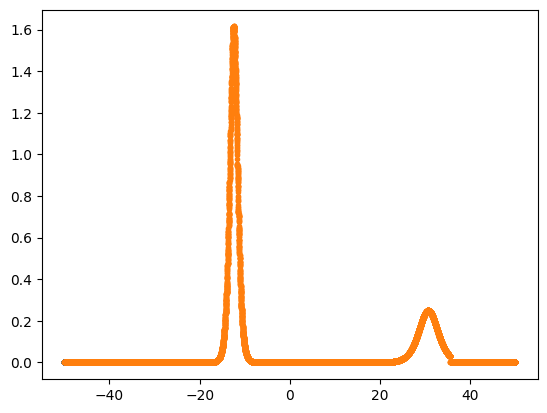

In [17]:
plt.plot(tx_boundary[:,1:],y_boundary,'.')
# plt.plot( tx_init[:,1:],u_init,'.')
plt.plot( tx_init[:,1:],phi_function(tx_init),'.')

inputs = [tx_eqn, tx_init, tx_boundary, tx_boundary, tx_boundary]
outputs = [phi_function(tx_eqn), y_eqn, y_init, y_boundary]


In [15]:
val =  tf.constant([[ 0.   ,    37.840843]], shape=(1, 2), dtype=tf.float32)
print(phi_function(val))

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


In [9]:
backbone = create_dense_model([64, 128, 128,128, 64], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)
pinn = KdVPinn(backbone, k=6.)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [15]:
history = pinn.fit_custom(inputs, outputs, epochs = 10000, print_every = 500)

Epoch 0, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0168
Epoch 500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0168
Epoch 1000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0168
Epoch 1500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0170
Epoch 2000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0170
Epoch 2500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0171
Epoch 3000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0171
Epoch 3500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0173
Epoch 4000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0173
Epoch 4500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0174
Epoch 5000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE:

In [ ]:
# history = pinn.fit(inputs, outputs, epochs= 20000, batch_size=tx_samples.shape[0], verbose=0)
# history = pinn.fit_custom(inputs, outputs, epochs=20000, print_every = 1000)

In [ ]:
pinn.get_metrics_result()


{'loss_total': <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 'loss_residual': <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 'loss_initial': <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 'loss_boundary': <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}

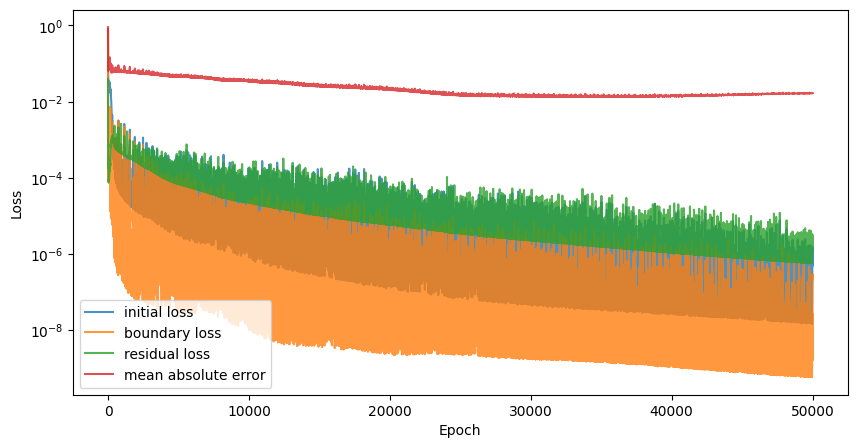

In [11]:
plot_training_loss(history, y_scale='log')

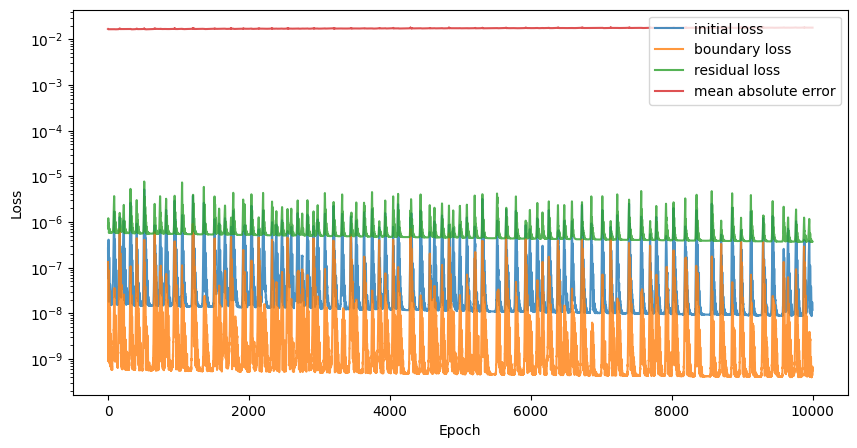

In [17]:
plot_training_loss(history, y_scale='log')

1/1 [==============================] - 0s 19ms/step


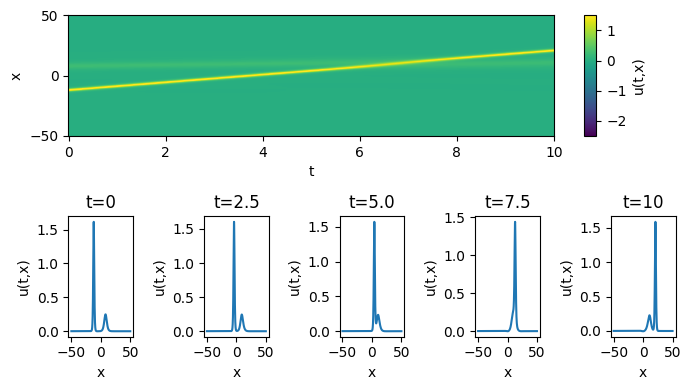

In [12]:
plot_KdV_model(pinn.backbone, x_start,length, time, -2.5, 1.5, save_path = None, show=True)

In [13]:
def plot_snapshots(timeList,num_test_samples = 1000):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    t_flat = tf.convert_to_tensor(t_flat)
    # t_, x_ = tf.meshgrid(t_flat, x_flat)
    # tx = tf.concat((tf.reshape(t_, (-1, 1)), tf.reshape(x_, (-1, 1))), axis=1)
    # solution = phi_function_PBC(tx,num_test_samples ,num_test_samples)
    # solution = tf.reshape(solution, x_.shape)
    dt=time/(num_test_samples-1)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        print(tx.shape)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction at time {}'.format(t_cs))
        print(int(t_cs/dt+1))
        # plt.plot(x_flat, solution[:,int(t_cs/dt)], label = 'exact')
        plt.plot(x_flat, phi_function(tx), '.',label = 'exact at time {}'.format(t_cs))
        plt.legend()
        plt.title('t={}'.format(np.round(t_cs,2)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
    return

(1000, 2)
1/1 [==============================] - 0s 19ms/step
750


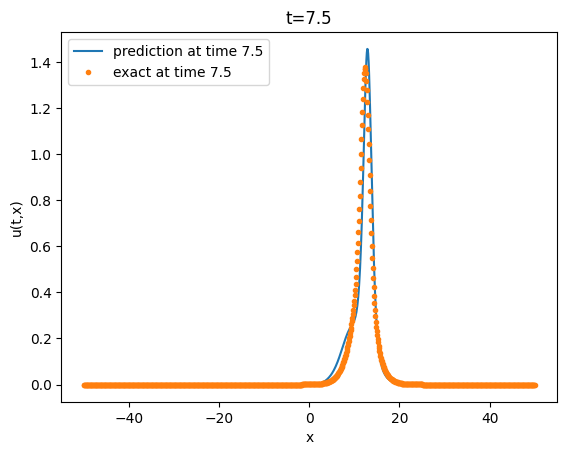

In [23]:
plot_snapshots([7.5])

In [ ]:
# print(phi_function(tx_eqn)[0:11])
# print(phi_function(tx_eqn[9:10,:]))
sol, denom, numer = phi_function(tx_init, returnStuff=True)
for ind,f in enumerate(tx_init):
    sol, denom, numer = phi_function(tx_init[ind:ind+1,:], returnStuff=True)
    if tf.math.is_nan(sol) == True:
        print(denom)
        print('numer', numer)
        print('values',tx_init[ind:ind+1,:])

# [[inf]]
# numer [[inf]]
# values tf.Tensor([[ 0.       37.840843]], shape=(1, 2), dtype=float32)
# [[inf]]
# numer [[inf]]
